In [1]:
%run 'Data Cleaning.ipynb'

In [2]:
jobs_cleaned.head()

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,scraped,skill_name,industry_name
0,3757940104,553718.0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,63000.0,NaN,MONTHLY,Full-time,"Little River, SC",...,NaN,1.699090e+12,careers-demant.icims.com,0,FULL_TIME,USD,BASE_SALARY,1699138101,Other,Medical Equipment Manufacturing
4,3757938018,18213359.0,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,46321.6,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,NaN,1.699080e+12,jobs.apploi.com,0,FULL_TIME,USD,BASE_SALARY,1699087461,Management,Non-profit Organizations
5,3757938018,18213359.0,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,46321.6,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,NaN,1.699080e+12,jobs.apploi.com,0,FULL_TIME,USD,BASE_SALARY,1699087461,Manufacturing,Non-profit Organizations
6,3757937095,437225.0,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,240895.0,205956.0,YEARLY,Full-time,United States,...,NaN,1.699090e+12,careers.iherb.com,0,FULL_TIME,USD,BASE_SALARY,1699085346,Information Technology,Retail
7,3757937095,437225.0,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,240895.0,205956.0,YEARLY,Full-time,United States,...,NaN,1.699090e+12,careers.iherb.com,0,FULL_TIME,USD,BASE_SALARY,1699085346,Information Technology,Manufacturing


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

med_P = np.nanpercentile(jobs_cleaned['med_salary'], [1, 99])
jobs_cleaned = jobs_cleaned[(jobs_cleaned['med_salary'] > med_P[0]) & (jobs_cleaned['med_salary'] < med_P[1])]

min_P = np.nanpercentile(jobs_cleaned['min_salary'], [1, 99])
jobs_cleaned = jobs_cleaned[(jobs_cleaned['min_salary'] > min_P[0]) & (jobs_cleaned['min_salary'] < min_P[1])]

max_P = np.nanpercentile(jobs_cleaned['max_salary'], [1, 99])
jobs_cleaned = jobs_cleaned[(jobs_cleaned['min_salary'] > max_P[0]) & (jobs_cleaned['min_salary'] < max_P[1])]

# jobs_cleaned.to_csv('jobs_cleaned.csv')

# Create a new LabelEncoder for each categorical column
title_encoder = LabelEncoder()
location_encoder = LabelEncoder()
skill_name_encoder = LabelEncoder()
experience_level_encoder = LabelEncoder()

# Fit and transform each column with its respective encoder
jobs_cleaned['title_enc'] = title_encoder.fit_transform(jobs_cleaned['title'])
jobs_cleaned['location_enc'] = location_encoder.fit_transform(jobs_cleaned['location'])
jobs_cleaned['skill_name_enc'] = skill_name_encoder.fit_transform(jobs_cleaned['skill_name'])
jobs_cleaned['formatted_experience_level_enc'] = experience_level_encoder.fit_transform(jobs_cleaned['formatted_experience_level'])


X = jobs_cleaned[['title_enc', 'location_enc','skill_name_enc','formatted_experience_level_enc']]

## XGBoost

In [4]:
def train_salary_model(salary_level):
    # Select the salary level for prediction
    y = jobs_cleaned[salary_level]
    
    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # Initializing and training the XGBoost regressor model
    # After running a few grid searches I found that each model had the same best parameters
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.2,
                              max_depth = 5, n_estimators = 1000)
    xg_reg.fit(X_train, y_train)

    # Making predictions on the test set
    y_pred = xg_reg.predict(X_test)

    # Calculating the RMSE for the predictions
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test,y_pred)

    
    # Returning the trained model
    return xg_reg, salary_level, y_test, y_pred, rmse, accuracy

In [5]:
def model_eval(model, salary_level, y_test, y_pred, rmse, accuracy):

    print(f"Salary Level: {salary_level}")
    print(f"RMSE: {rmse}")
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual Salaries')
    plt.ylabel('Predicted Salaries')
    plt.title(f'Actual vs. Predicted Salaries ({salary_level})')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.show()

Salary Level: min_salary
RMSE: 19561.937608640066


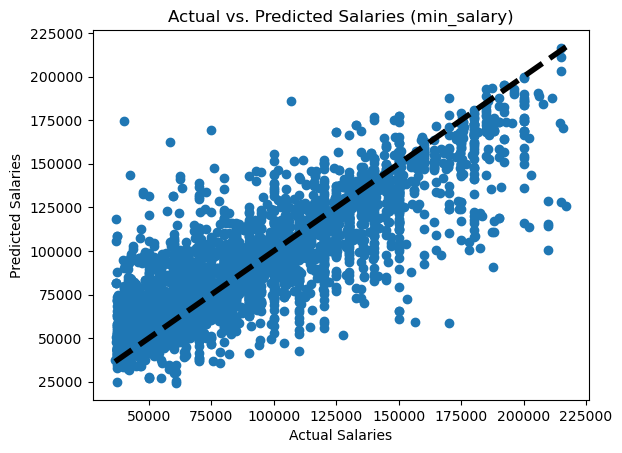

Salary Level: max_salary
RMSE: 33747.612064048335


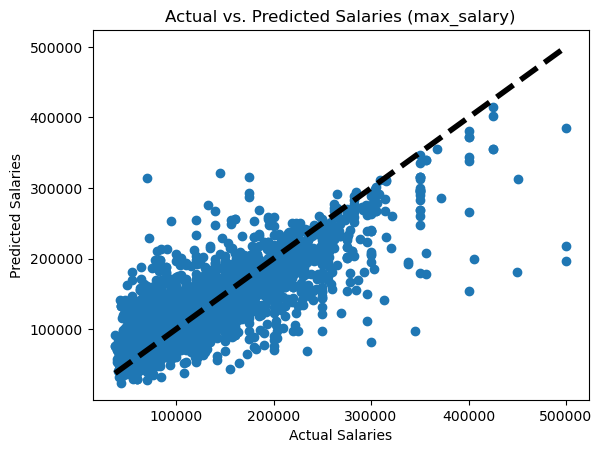

Salary Level: med_salary
RMSE: 25304.888541811422


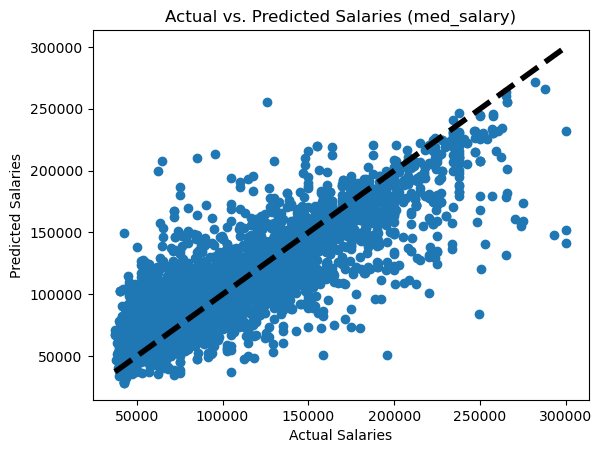

In [6]:
models = ['min_salary','max_salary','med_salary']
for model in models:
    model_eval(*train_salary_model(model))

In [7]:

med_salary_model, salary_level, y_test, y_pred, rmse = train_salary_model('med_salary')
min_salary_model, _, _, _, _ = train_salary_model('min_salary')
max_salary_model, _, _, _, _ = train_salary_model('max_salary')


# med_salary_model.save_model('med_model.json')
# min_salary_model.save_model('min_model.json')
# max_salary_model.save_model('max_model.json')

In [8]:
pd.DataFrame({'Actual':y_test,'Predicted':y_pred}).reset_index(drop=True).to_csv('med_preds.csv')

In [9]:
# xgb = xgb.XGBRegressor()

# xgb.load_model('med_model.json')

### Min, Median, Max estimator

In [10]:
med_salary_model, _, _, _, _ = train_salary_model('med_salary')
min_salary_model, _, _, _, _ = train_salary_model('min_salary')
max_salary_model, _, _, _, _ = train_salary_model('max_salary')

# Example user input
for location in jobs_cleaned['location'].unique():
    user_input = {
        'title_enc': ['Data Scientist'],
        'location_enc': [f'{location}'],
        'skill_name_enc': ['Information Technology'],
        'formatted_experience_level_enc': ['Mid-Senior level']
    }

    user_input_df = pd.DataFrame(user_input)

    user_input_df['title_enc'] = title_encoder.transform(user_input_df['title_enc'])
    user_input_df['location_enc'] = location_encoder.transform(user_input_df['location_enc'])
    user_input_df['skill_name_enc'] = skill_name_encoder.transform(user_input_df['skill_name_enc'])
    user_input_df['formatted_experience_level_enc'] = experience_level_encoder.transform(user_input_df['formatted_experience_level_enc'])

    # Predict the salary for the user input
    min_predicted_salary = min_salary_model.predict(user_input_df)
    median_predicted_salary = med_salary_model.predict(user_input_df)
    max_predicted_salary = max_salary_model.predict(user_input_df)

    print(f"----{location}-----")
    print(f"\n Estimated salary: ${min_predicted_salary[0]:,.2f} - ${median_predicted_salary[0]:,.2f} - ${max_predicted_salary[0]:,.2f} \n")

----United States-----

 Estimated salary: $178,061.89 - $179,927.61 - $199,546.45 

----Coeur d'Alene, ID-----

 Estimated salary: $119,609.68 - $152,732.09 - $178,474.73 

----Waukesha, WI-----

 Estimated salary: $148,249.98 - $159,689.50 - $175,598.72 

----Orlando, FL-----

 Estimated salary: $112,604.21 - $142,495.53 - $180,743.95 

----Oakland, CA-----

 Estimated salary: $121,313.99 - $145,285.69 - $184,864.66 

----Broomfield, CO-----

 Estimated salary: $111,316.87 - $131,873.30 - $184,125.64 

----Swedesboro, NJ-----

 Estimated salary: $147,881.64 - $152,803.86 - $182,284.91 

----Richmond, VA-----

 Estimated salary: $110,416.65 - $169,684.47 - $186,306.58 

----Rapid City, SD-----

 Estimated salary: $100,413.95 - $156,257.98 - $217,177.59 

----Yuma, AZ-----

 Estimated salary: $126,169.67 - $150,310.66 - $175,268.92 

----Sheboygan, WI-----

 Estimated salary: $135,255.16 - $164,519.23 - $194,400.12 

----Portland, OR-----

 Estimated salary: $116,168.04 - $160,588.42 -

----Plano, TX-----

 Estimated salary: $117,645.16 - $154,312.00 - $195,740.36 

----Sunnyvale, CA-----

 Estimated salary: $147,881.64 - $152,803.86 - $182,284.91 

----Baltimore County, MD-----

 Estimated salary: $110,202.62 - $131,611.70 - $185,732.25 

----Los Angeles, California, United States-----

 Estimated salary: $104,650.11 - $140,003.20 - $141,993.08 

----San Francisco Bay Area-----

 Estimated salary: $150,921.86 - $179,409.58 - $200,138.61 

----McLean, VA-----

 Estimated salary: $116,551.11 - $156,114.95 - $189,809.22 

----Newport, MI-----

 Estimated salary: $111,489.14 - $141,428.00 - $185,854.36 

----Dallas, TX-----

 Estimated salary: $138,686.89 - $175,520.41 - $207,082.66 

----South San Francisco, CA-----

 Estimated salary: $124,115.70 - $153,916.89 - $168,188.42 

----Oklahoma City, OK-----

 Estimated salary: $121,313.99 - $145,285.69 - $184,864.66 

----San Mateo, CA-----

 Estimated salary: $171,248.58 - $202,400.19 - $224,114.17 

----New York, United S

----Illinois, United States-----

 Estimated salary: $126,035.82 - $158,194.98 - $196,469.50 

----Akron, OH-----

 Estimated salary: $75,694.34 - $83,241.93 - $113,800.58 

----Sterling, VA-----

 Estimated salary: $126,821.41 - $141,018.03 - $161,540.70 

----Indiana, United States-----

 Estimated salary: $111,229.23 - $150,685.50 - $161,799.22 

----Santa Cruz County, CA-----

 Estimated salary: $131,485.80 - $161,018.47 - $192,999.66 

----Crete, NE-----

 Estimated salary: $129,461.58 - $185,047.12 - $240,874.09 

----Euless, TX-----

 Estimated salary: $104,526.63 - $126,325.41 - $144,090.14 

----Bradenton, FL-----

 Estimated salary: $123,743.79 - $145,668.45 - $198,738.03 

----Manassas, VA-----

 Estimated salary: $115,960.14 - $149,121.66 - $175,387.69 

----Chantilly, VA-----

 Estimated salary: $123,993.65 - $155,278.25 - $203,462.89 

----Franklin, VA-----

 Estimated salary: $110,638.60 - $150,945.50 - $180,532.94 

----Bronx, NY-----

 Estimated salary: $130,836.99 - $

----Austell, GA-----

 Estimated salary: $117,631.45 - $152,223.97 - $207,960.25 

----Puyallup, WA-----

 Estimated salary: $104,002.85 - $190,482.59 - $280,227.03 

----Burbank, CA-----

 Estimated salary: $109,565.20 - $135,833.05 - $187,758.34 

----Elma, NY-----

 Estimated salary: $109,530.47 - $128,676.32 - $155,051.84 

----Columbia, MD-----

 Estimated salary: $114,762.26 - $146,379.41 - $178,670.70 

----Romulus, MI-----

 Estimated salary: $101,819.09 - $143,580.17 - $178,089.06 

----Springfield, MA-----

 Estimated salary: $103,277.15 - $145,150.11 - $158,895.41 

----Utica, NY-----

 Estimated salary: $178,061.89 - $179,927.61 - $199,546.45 

----Rutland, VT-----

 Estimated salary: $104,375.07 - $143,628.47 - $174,555.39 

----Syracuse, NY-----

 Estimated salary: $147,881.64 - $152,803.86 - $182,284.91 

----Wilson, NC-----

 Estimated salary: $137,942.11 - $180,116.55 - $209,354.22 

----Virginia Beach, VA-----

 Estimated salary: $140,197.38 - $163,547.77 - $179,465.4

----Johnson City-Kingsport-Bristol Area-----

 Estimated salary: $135,668.28 - $185,036.50 - $183,378.70 

----San Ramon, CA-----

 Estimated salary: $171,248.58 - $202,400.19 - $224,114.17 

----Denville, NJ-----

 Estimated salary: $123,423.78 - $157,536.67 - $193,871.36 

----Manhattan, NY-----

 Estimated salary: $115,960.14 - $149,121.66 - $175,387.69 

----Stafford, TX-----

 Estimated salary: $136,359.47 - $144,335.42 - $178,235.58 

----Wharton, NJ-----

 Estimated salary: $137,942.11 - $180,116.55 - $209,354.22 

----Grapevine, TX-----

 Estimated salary: $112,918.90 - $136,488.84 - $157,764.69 

----Miami-Fort Lauderdale Area-----

 Estimated salary: $138,392.36 - $141,116.53 - $169,528.56 

----Peachtree Corners, GA-----

 Estimated salary: $103,264.84 - $140,252.78 - $170,122.28 

----Columbia, SC-----

 Estimated salary: $116,388.80 - $148,569.02 - $175,515.22 

----Falls Church, VA-----

 Estimated salary: $114,781.64 - $132,981.02 - $150,607.06 

----Billerica, MA-----



----Santa Barbara, CA-----

 Estimated salary: $151,465.52 - $177,340.33 - $209,764.09 

----Oregon, United States-----

 Estimated salary: $111,249.38 - $141,050.67 - $181,918.45 

----Fairbanks, AK-----

 Estimated salary: $104,526.63 - $126,325.41 - $144,090.14 

----Roy, UT-----

 Estimated salary: $104,375.07 - $143,628.47 - $174,555.39 

----Santa Maria, CA-----

 Estimated salary: $133,735.45 - $157,919.78 - $187,852.53 

----Apex, NC-----

 Estimated salary: $103,358.34 - $130,320.66 - $170,304.81 

----Brier, WA-----

 Estimated salary: $123,743.79 - $145,668.45 - $198,738.03 

----San Fernando, CA-----

 Estimated salary: $113,249.36 - $157,002.22 - $173,736.52 

----Campbell, FL-----

 Estimated salary: $128,243.52 - $157,996.73 - $217,445.55 

----College Park, MD-----

 Estimated salary: $119,609.68 - $152,732.09 - $178,474.73 

----Madison Heights, MI-----

 Estimated salary: $108,365.98 - $148,189.27 - $151,297.55 

----Brentwood, TN-----

 Estimated salary: $123,743.79 

----Baldwinsville, NY-----

 Estimated salary: $110,202.62 - $131,611.70 - $185,732.25 

----Hutchins, TX-----

 Estimated salary: $126,035.82 - $158,194.98 - $196,469.50 

----Farmington Hills, MI-----

 Estimated salary: $114,781.64 - $132,981.02 - $150,607.06 

----Catskill, NY-----

 Estimated salary: $123,851.38 - $154,654.22 - $201,899.78 

----Grayson, GA-----

 Estimated salary: $112,918.90 - $136,488.84 - $157,764.69 

----Mayfield Heights, OH-----

 Estimated salary: $103,015.66 - $146,621.89 - $171,775.45 

----Chattanooga, TN-----

 Estimated salary: $116,987.41 - $144,698.80 - $200,827.72 

----Bethesda, MD-----

 Estimated salary: $110,035.28 - $146,572.05 - $193,797.91 

----Greater Jackson, MI Area-----

 Estimated salary: $125,423.13 - $151,590.83 - $172,822.02 

----Perrysburg, OH-----

 Estimated salary: $106,175.66 - $146,603.95 - $175,810.14 

----St Louis Park, MN-----

 Estimated salary: $103,277.15 - $145,150.11 - $158,895.41 

----Kenilworth, NJ-----

 Estimate

----Willimantic, CT-----

 Estimated salary: $137,942.11 - $180,116.55 - $209,354.22 

----Yerington, NV-----

 Estimated salary: $126,169.67 - $150,310.66 - $175,268.92 

----Denver, NC-----

 Estimated salary: $123,423.78 - $157,536.67 - $193,871.36 

----Casper, WY-----

 Estimated salary: $123,851.38 - $154,654.22 - $201,899.78 

----Michigan, United States-----

 Estimated salary: $138,392.36 - $141,116.53 - $169,528.56 

----San Francisco County, CA-----

 Estimated salary: $150,921.86 - $179,409.58 - $200,138.61 

----Tempe, AZ-----

 Estimated salary: $155,868.08 - $157,743.62 - $174,510.97 

----Itasca, IL-----

 Estimated salary: $102,529.30 - $148,101.66 - $159,099.97 

----Joplin, MO-----

 Estimated salary: $135,668.28 - $185,036.50 - $183,378.70 

----Thousand Oaks, California, United States-----

 Estimated salary: $151,611.73 - $148,131.39 - $176,891.39 

----Palmdale, CA-----

 Estimated salary: $109,999.14 - $144,483.59 - $189,119.41 

----San Mateo County, CA-----

 

----Hollywood, FL-----

 Estimated salary: $119,613.82 - $143,001.27 - $181,561.52 

----Mendota Heights, MN-----

 Estimated salary: $141,897.52 - $152,773.70 - $178,712.39 

----West Babylon, NY-----

 Estimated salary: $147,127.30 - $162,533.22 - $178,087.05 

----Memphis Metropolitan Area-----

 Estimated salary: $141,897.52 - $152,773.70 - $178,712.39 

----Passaic, NJ-----

 Estimated salary: $103,264.84 - $140,252.78 - $170,122.28 

----Memphis metropolitan area, MS-----

 Estimated salary: $141,897.52 - $152,773.70 - $178,712.39 

----Duluth, MN-----

 Estimated salary: $125,370.75 - $161,223.22 - $191,236.41 

----Woburn, MA-----

 Estimated salary: $138,055.75 - $166,225.52 - $192,005.64 

----Tallahassee, FL-----

 Estimated salary: $153,925.48 - $147,022.55 - $176,965.28 

----Ronkonkoma, NY-----

 Estimated salary: $101,819.09 - $143,580.17 - $178,089.06 

----Silicon Valley, CA-----

 Estimated salary: $127,460.74 - $158,676.09 - $180,872.78 

----Johnstown, CO-----

 Est

----Norwood, MA-----

 Estimated salary: $111,526.73 - $136,762.97 - $184,748.17 

----Westlake, TX-----

 Estimated salary: $155,662.25 - $185,545.44 - $203,711.52 

----Roseland, NJ-----

 Estimated salary: $101,819.09 - $143,580.17 - $178,089.06 

----San Leandro, CA-----

 Estimated salary: $144,979.20 - $172,925.70 - $199,259.22 

----Smithfield, RI-----

 Estimated salary: $127,460.74 - $158,676.09 - $180,872.78 

----Harrison, NY-----

 Estimated salary: $117,006.73 - $147,758.36 - $174,255.06 

----Kohler, WI-----

 Estimated salary: $113,267.30 - $158,877.80 - $174,527.72 

----Alpharetta, GA-----

 Estimated salary: $105,282.81 - $133,123.33 - $179,195.47 

----Coraopolis, PA-----

 Estimated salary: $132,225.41 - $174,475.05 - $220,534.44 

----Beaumont, TX-----

 Estimated salary: $109,975.01 - $136,946.86 - $182,558.39 

----Daly City, CA-----

 Estimated salary: $140,914.86 - $183,088.12 - $223,866.36 

----Forest Home, NY-----

 Estimated salary: $129,322.52 - $183,227.2

----Tupelo, MS-----

 Estimated salary: $155,025.91 - $175,143.39 - $216,522.45 

----Ellicott City, MD-----

 Estimated salary: $109,530.47 - $128,676.32 - $155,051.84 

----Yorktown, NY-----

 Estimated salary: $126,169.67 - $150,310.66 - $175,268.92 

----Rigby, ID-----

 Estimated salary: $110,416.65 - $169,684.47 - $186,306.58 

----Covina, CA-----

 Estimated salary: $129,461.58 - $185,047.12 - $240,874.09 

----Azusa, CA-----

 Estimated salary: $104,297.66 - $127,918.10 - $179,296.08 

----Put-in-Bay Township, OH-----

 Estimated salary: $112,326.70 - $160,726.55 - $200,502.92 

----Oakbrook Terrace, IL-----

 Estimated salary: $112,172.99 - $136,492.91 - $185,401.94 

----Vienna, VA-----

 Estimated salary: $140,197.38 - $163,547.77 - $179,465.44 

----Merritt Island, FL-----

 Estimated salary: $129,902.88 - $141,124.94 - $168,865.12 

----Iva, SC-----

 Estimated salary: $102,529.30 - $148,101.66 - $159,099.97 

----Douglasville, GA-----

 Estimated salary: $124,942.63 - $16

----Blythe, CA-----

 Estimated salary: $98,808.64 - $125,350.19 - $168,478.19 

----Bethlehem, PA-----

 Estimated salary: $110,035.28 - $146,572.05 - $193,797.91 

----Ahwatukee, AZ-----

 Estimated salary: $75,694.34 - $83,241.93 - $113,800.58 

----Del Mar, CA-----

 Estimated salary: $111,239.34 - $139,596.78 - $175,990.64 

----Lihue, HI-----

 Estimated salary: $116,384.76 - $158,330.42 - $175,686.19 

----Syosset, NY-----

 Estimated salary: $147,881.64 - $152,803.86 - $182,284.91 

----Albuquerque-Santa Fe Metropolitan Area-----

 Estimated salary: $90,981.44 - $123,158.18 - $167,153.84 

----Alameda, CA-----

 Estimated salary: $75,694.34 - $83,241.93 - $113,800.58 

----Trussville, AL-----

 Estimated salary: $144,575.73 - $153,250.02 - $174,707.22 

----Lincoln, NE-----

 Estimated salary: $116,384.76 - $158,330.42 - $175,686.19 

----Wixom, MI-----

 Estimated salary: $138,055.75 - $166,225.52 - $192,005.64 

----Michigan City, IN-----

 Estimated salary: $138,392.36 - $14

### Job Title Similarity Search

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# List of job titles
job_titles = jobs_cleaned['title'].unique()

# User input job title
user_input_title = input("Enter job title: ")

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the job titles to TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(job_titles)

# Transform the user input job title to TF-IDF vector
user_input_vector = tfidf_vectorizer.transform([user_input_title])

# Compute the cosine similarity between user input job title and each job title in the list
cos_similarity = cosine_similarity(user_input_vector, tfidf_matrix)[0]

# Find the indices of the top 5 cosine similarity scores
top_5_indices = np.argsort(cos_similarity)[-5:]

# Find the most similar job titles in the list
most_similar_job_titles = job_titles[top_5_indices]

# Reverse the array to have the most similar first
most_similar_job_titles = np.flip(most_similar_job_titles)

print("The top 5 most similar job titles are:", most_similar_job_titles)


KeyboardInterrupt: Interrupted by user

### Job Description Similarity Search

In [ ]:
# Remove duplicates based on job titles to ensure uniqueness
jobs_cleaned_unique_titles = jobs_cleaned.drop_duplicates(subset='title', keep='first')

# Work with the deduplicated dataset
jobs = jobs_cleaned_unique_titles[['title', 'description']]
job_descriptions = jobs['description'].tolist()
job_titles = jobs['title'].tolist() 

# User inputs their job description
user_input_description = input("Enter job description: ")

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the job descriptions to a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(job_descriptions)

# Transform the user input job description into a TF-IDF vector
user_input_vector = tfidf_vectorizer.transform([user_input_description])

# Compute the cosine similarity between the user input and each job description
cos_similarity = cosine_similarity(user_input_vector, tfidf_matrix)[0]

# Find the indices of the top 5 cosine similarity scores
top_5_indices = np.argsort(cos_similarity)[-5:]

# Retrieve the job titles corresponding to these top 5 indices
most_similar_job_titles = [jobs.iloc[i]['title'] for i in top_5_indices]

# Reverse the list to have the most similar first
most_similar_job_titles.reverse()

print("The top 5 most related job titles are:", most_similar_job_titles)
